In [8]:
%cd /home/dongmin/23FW-NCG/jeongganbo-omr
%load_ext autoreload
%autoreload 2

/home/dongmin/23FW-NCG/jeongganbo-omr
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
import re
import glob
from random import randint, choice, uniform
import pickle

from tqdm import tqdm

import cv2
import numpy as np
import matplotlib.pyplot as plt

from exp_utils import JeongganSynthesizer
from omr_cnn import get_img_paths

# Jng Synthesizer

## PATHS

In [44]:
jng_img_path_dict = get_img_paths('test/synth/src', ['notes', 'symbols'])
jng_synth = JeongganSynthesizer(jng_img_path_dict)

느나:1 느나니나:3 청협:5 청협:8
[['느나', '1'], ['느나니나', '3'], ['청협', '5'], ['청협', '8']]


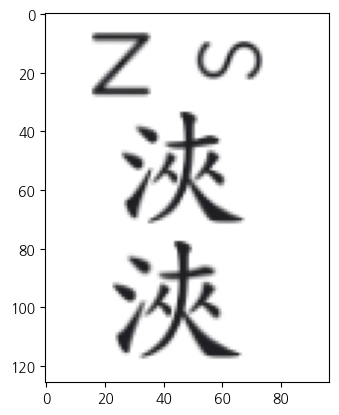

In [108]:
label, img = jng_synth()

print(label)
print(jng_synth.label2dict(label))

plt.imshow(img)

In [7]:
width, height = jng_synth.get_size()
pitch_range = jng_synth.get_pitch_range()
jng_dict = jng_synth.get_jng_dict(pitch_range)

jng_arr = [ row['cols'] for row in jng_dict['rows'] ]

jng_infos = []
row_heights = []

for row in jng_arr:
  new_col = []
  row_height = []
  for col in row:
    note_img_path = jng_img_path_dict[col]
    
    if isinstance(note_img_path, list):
      note_img_path = choice(note_img_path)
    
    note_img = cv2.imread(note_img_path)
    
    new_col.append( (col, note_img.shape[:2], note_img) )
    row_height.append(note_img.shape[0])
  
  jng_infos.append(new_col)
  row_heights.append(max(row_height))


jng_dict, jng_infos

({'row_div': 3,
  'rows': [{'col_div': 1, 'cols': ['joong_dd']},
   {'col_div': 1, 'cols': ['joong_dd']},
   {'col_div': 1, 'cols': ['joong_dd']}]},
 [[('joong_dd',
    (43, 48),
    array([[[255, 255, 255],
            [255, 255, 255],
            [255, 255, 255],
            ...,
            [255, 255, 255],
            [255, 255, 255],
            [255, 255, 255]],
    
           [[255, 255, 255],
            [255, 255, 255],
            [255, 255, 255],
            ...,
            [255, 255, 255],
            [255, 255, 255],
            [255, 255, 255]],
    
           [[255, 255, 255],
            [255, 255, 255],
            [255, 255, 255],
            ...,
            [255, 255, 255],
            [255, 255, 254],
            [255, 255, 254]],
    
           ...,
    
           [[255, 255, 255],
            [255, 255, 255],
            [255, 255, 255],
            ...,
            [255, 255, 255],
            [255, 255, 255],
            [255, 255, 255]],
    
           [

findfont: Font family 'AppleMyungjo' not found.
findfont: Font family 'AppleMyungjo' not found.
findfont: Font family 'AppleMyungjo' not found.
findfont: Font family 'AppleMyungjo' not found.
findfont: Font family 'AppleMyungjo' not found.
findfont: Font family 'AppleMyungjo' not found.
findfont: Font family 'AppleMyungjo' not found.
findfont: Font family 'AppleMyungjo' not found.
findfont: Font family 'AppleMyungjo' not found.
findfont: Font family 'AppleMyungjo' not found.
findfont: Font family 'AppleMyungjo' not found.
findfont: Font family 'AppleMyungjo' not found.
findfont: Font family 'AppleMyungjo' not found.
findfont: Font family 'AppleMyungjo' not found.
findfont: Font family 'AppleMyungjo' not found.
findfont: Font family 'AppleMyungjo' not found.
findfont: Font family 'AppleMyungjo' not found.
findfont: Font family 'AppleMyungjo' not found.
findfont: Font family 'AppleMyungjo' not found.
findfont: Font family 'AppleMyungjo' not found.
findfont: Font family 'AppleMyungjo' not

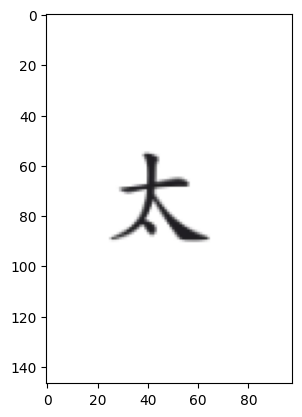

In [16]:
DEFAULT_MARGIN = 6
MARK_HEIGHT = 26
self = jng_synth

def generate_image_by_dict(self, img, dict, apply_noise=True):
  img_h, img_w = img.shape[:2]
  
  jng_arr = [ row['cols'] for row in jng_dict['rows'] ]
  row_div = len(jng_arr)

  jng_infos = []
  row_heights = []

  for row_idx, row in enumerate(jng_arr):
    new_row = []
    row_height = []
    
    for note_name in row:
      note_img_path = jng_img_path_dict[note_name]
      
      if isinstance(note_img_path, list):
        note_img_path = choice(note_img_path)
      
      note_img = cv2.imread(note_img_path, cv2.IMREAD_UNCHANGED)
      note_img_dim = list(note_img.shape[:2])
      
      if note_name == 'conti' and len(row) == 1:
        note_img_dim[0] = MARK_HEIGHT
      
      new_row.append( [note_name, note_img_dim, note_img] )
      row_height.append(note_img_dim[0])
    
    jng_infos.append(new_row)
    row_heights.append(max(row_height))

  row_margin = randint(1, DEFAULT_MARGIN)
  
  if sum(row_heights) > img_h - 2*row_margin:
    ignore = []
    valid = []
    
    for rh in row_heights:
      if rh < 10:
        ignore.append(rh)
      else:
        valid.append(rh * 1.2)
    
    h_size_ratio = (img_h - 2*row_margin - sum(ignore))/sum(valid)
    
    new_jng_infos = []
    new_row_heights = []
    
    for row in jng_infos:
      new_row = []
      new_row_height = []
      
      for col in row:
        note_name, note_img_dim, note_img = col
        
        if note_img_dim[0] > 9:
          note_img_dim[0] = int(note_img_dim[0] * h_size_ratio)
        
        if note_name == 'pause':
          note_img_dim[1] = int(note_img_dim[1] * h_size_ratio)
        
        new_row.append([note_name, note_img_dim, note_img])
        new_row_height.append(note_img_dim[0])
      
      new_jng_infos.append(new_row)
      new_row_heights.append(max(new_row_height))
    
    jng_infos = new_jng_infos
    row_heights = new_row_heights
    
    del new_jng_infos
    del new_row_heights

  row_gap = int((img_h - 2*row_margin - sum(row_heights)) / (row_div + 1))
  row_template = [ row_margin + sum(row_heights[:idx]) + (idx + 1) * row_gap for idx in range(row_div) ]

  col_margin = randint(0, DEFAULT_MARGIN)
  
  for row_idx, row in enumerate(jng_infos):
    col_div = len(row)
    
    if sum([ img_dim[1] for _, img_dim, _ in row ]) > img_w - 2*row_margin:
      ignore = []
      valid = []
      
      for note_name, note_img_dim, _ in row:
        if note_name == 'conti':
          ignore.append(note_img_dim[1])
        else:
          valid.append(note_img_dim[1] * 1.2)
      
      w_size_ratio = (img_w - 2*col_margin - sum(ignore))/sum(valid)
      
      new_row = []
      
      for note_name, note_img_dim, note_img in row:
        if note_name != 'conti':
          note_img_dim[1] = int(note_img_dim[1] * w_size_ratio)
        
        if note_name == 'pause':
          note_img_dim[0] = int(note_img_dim[0] * w_size_ratio)
        
        new_row.append([note_name, note_img_dim, note_img])
      
      row = new_row
      del new_row
    
    notes = [] 
    for note_name, note_img_dim, note_img in row:
      if any([tar != src for tar, src in zip(note_img_dim, note_img.shape[:2])]):
        if note_name == 'conti':
          note_img = self.make_mark(note_img, note_img_dim[0])
        else:
          note_img = cv2.resize(note_img, dsize=note_img_dim[-1::-1])
      
      notes.append((note_img, note_name))
    
    row_width = sum([ img.shape[1] for img, _ in notes ])
    col_gap = (img_w - 2*col_margin - row_width) // (col_div + 1)
    col_template = [ col_margin + sum([ img.shape[1] for img, _ in notes ][:idx]) + (idx + 1) * col_gap for idx in range(col_div) ]
    
    for col_idx, note_tuple in enumerate(notes):
      note_img, note_name = note_tuple
      
      # size noise
      if apply_noise:
        rand_ratio = uniform(0.8, 1.1)
        note_img = self.resize_img_by_height(note_img, round(note_img.shape[0] * rand_ratio))
      
      pos_x = col_template[col_idx]
      pos_y = row_template[row_idx]
      
      if row_heights[row_idx] != note_img.shape[0]:
        pos_y += row_heights[row_idx]//2 - note_img.shape[0]//2
      
      if apply_noise:
        pos_x += randint(-3, 3)
        pos_y += randint(-3, 3)
    
      note_img = self.remove_background(note_img)
    
      img = self.insert_img(img, note_img, pos_x, pos_y)
  
  return img

width, height = jng_synth.get_size()
img = jng_synth.get_blank(width, height)
pitch_range = jng_synth.get_pitch_range()
jng_dict = jng_synth.get_jng_dict(pitch_range)

plt.imshow(generate_image_by_dict(self, img, jng_dict))

In [68]:
NUM = 1_400_000
fail_cnt = 0
exception_list = []

for idx in tqdm(range(NUM), leave=False):
  width, height = jng_synth.get_size()
  img = jng_synth.get_blank(width, height)
  pitch_range = jng_synth.get_pitch_range()
  jng_dict = jng_synth.get_jng_dict(pitch_range)

  try: 
    generate_image_by_dict(self, img, jng_dict)
  
  except Exception as e:
    fail_cnt += 1
    exception_list.append([(width, height, jng_dict), e])

fail_cnt

  0%|          | 0/1400000 [00:00<?, ?it/s]

1

In [69]:
exception_list

[[(96,
   96,
   {'row_div': 3,
    'rows': [{'col_div': 2, 'cols': ['eung', 'conti']},
     {'col_div': 1, 'cols': ['lim']},
     {'col_div': 1, 'cols': ['conti']}]}),
  ValueError('operands could not be broadcast together with shapes (0,16) (2,16) ')]]

{'row_div': 3, 'rows': [{'col_div': 2, 'cols': ['eung', 'conti']}, {'col_div': 1, 'cols': ['lim']}, {'col_div': 1, 'cols': ['conti']}]}


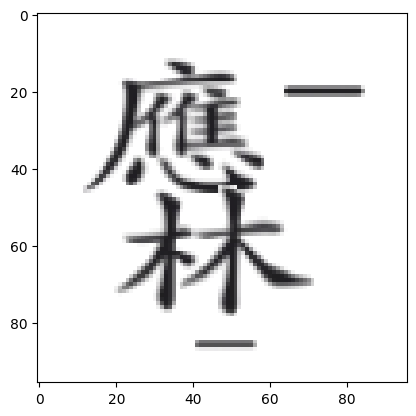

In [120]:
width, height, jng_dict = exception_list[0][0]

img = jng_synth.get_blank(width, height)
print(jng_dict)

plt.imshow(generate_image_by_dict(self, img, jng_dict))

In [11]:
import pickle

with open('test/synth/edge_cases_240218.p', 'wb') as f:
  pickle.dump([ settings for settings, e in exception_list], f)

In [10]:
with open('test/synth/edge_cases_240218.p', 'rb') as f:
  edge_settings = pickle.load(f)

{'row_div': 3, 'rows': [{'col_div': 2, 'cols': ['eung_d', 'hyeop_d']}, {'col_div': 2, 'cols': ['eung_d', 'tae_d']}, {'col_div': 2, 'cols': ['hwang', 'conti']}]}
eung_d [14, 31] 0.6597938144329897
tae_d [13, 32] 0.6597938144329897


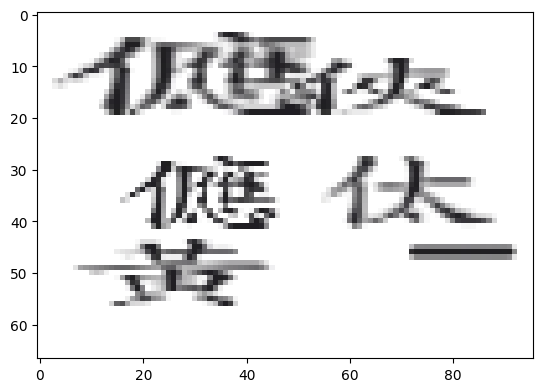

In [33]:
width, height, jng_dict = edge_settings[0]

img = jng_synth.get_blank(width, height)
print(jng_dict)

plt.imshow(generate_image_by_dict(self, img, jng_dict))


In [5]:
NUM = 30

plt.rcParams.update({'font.family': 'NanumGothic'})
plt.figure(figsize=(20, 10))

for idx in range(NUM):
  width, height = jng_synth.get_size()
  img = jng_synth.get_blank(width, height)
  pitch_range = jng_synth.get_pitch_range()
  jng_dict, label =jng_synth.get_label_dict()
  
  img = generate_image_by_dict(self, img, jng_dict)
  
  plt.subplot(5, 6, idx+1)
  plt.imshow(img)
  plt.title(f'{label}')

NameError: name 'generate_image_by_dict' is not defined

<Figure size 2000x1000 with 0 Axes>